In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
from scipy import signal
import cv2
from scipy import ndimage
import pywt

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def plotImage(img):
    fig = plt.figure(figsize=(10,10))
    plt.gray()  
    plt.imshow(img)
    plt.show() 

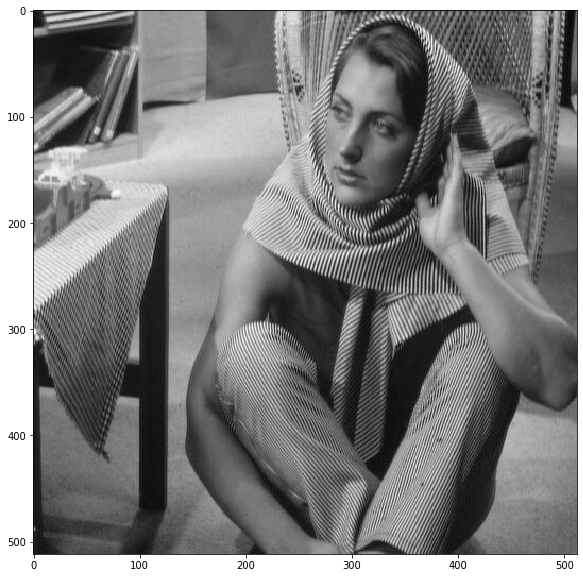

In [7]:
# Open barbara image
barb = mpimg.imread("barbara.jpg")
barb_grey = rgb2gray(barb)

barb_grey = barb_grey/255
plotImage(barb_grey)

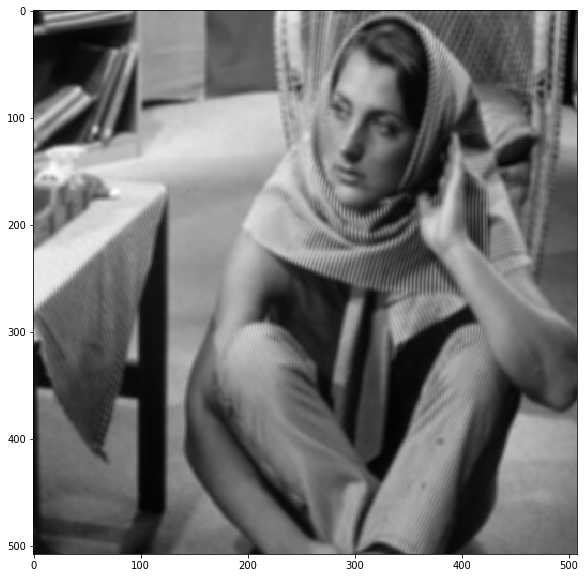

In [8]:
##On applique une convolution sur l'image, afin de simuler un capteur avec une résolution assez basse. On utilise un filtre de 
##5x5
barb_conv = scipy.signal.convolve2d(barb_grey, (1/25)*np.ones((5,5)), mode='valid')  
plotImage(barb_conv)

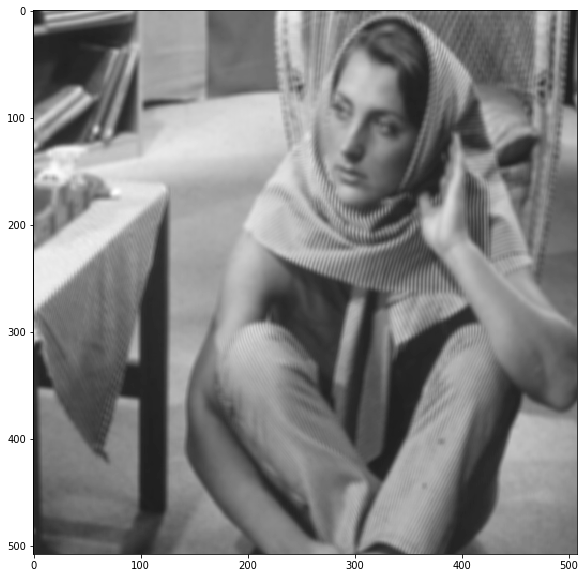

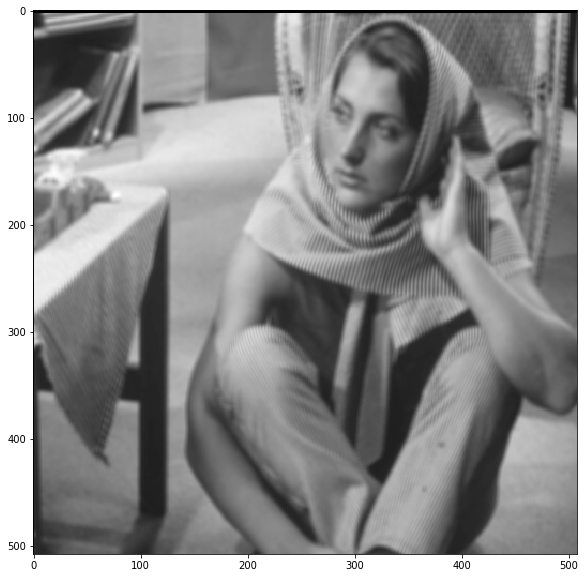

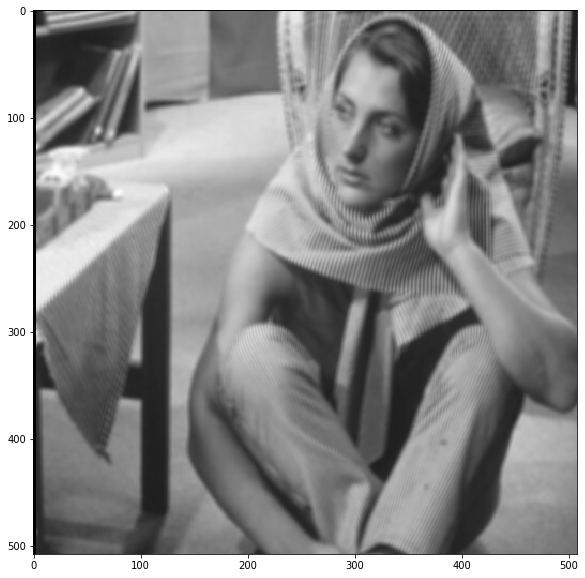

In [30]:
##On génère 3 images avec des translations fixées. 
n_row, n_col = barb_conv.shape

translations = [(0,1),(3,1),(1,3)]

barb_trans = []
for translation in translations:
    barb_trans.append(scipy.ndimage.shift(barb_conv, translation))
    
for img in barb_trans:
    plotImage(img)

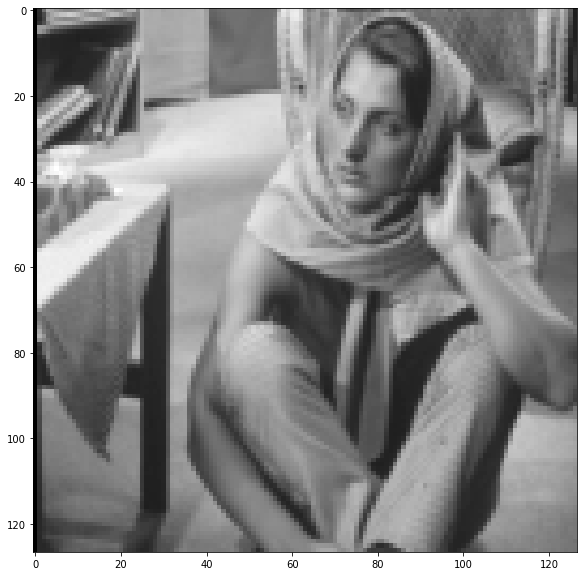

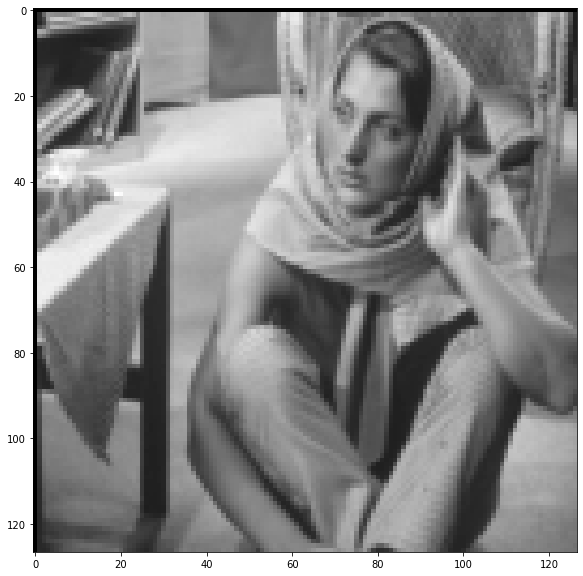

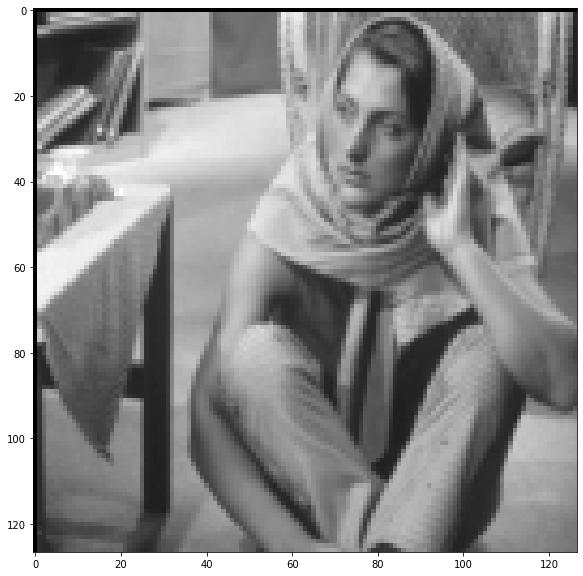

In [31]:
## On down sample les images pour simuler une mauvaise résolution
step = 4
barb_downs = []
for barb_tran in barb_trans:
    barb_downs.append(barb_tran[:barb_tran.shape[0]:step, :barb_tran.shape[1]:step])

plotImage(barb_downs[0])
plotImage(barb_downs[1])
plotImage(barb_downs[2])

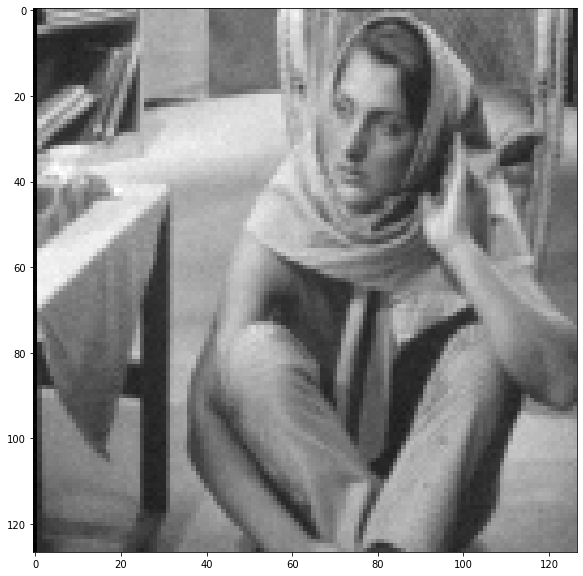

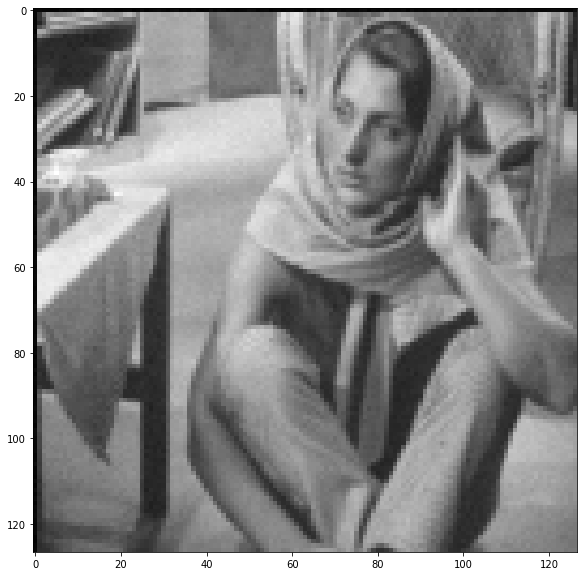

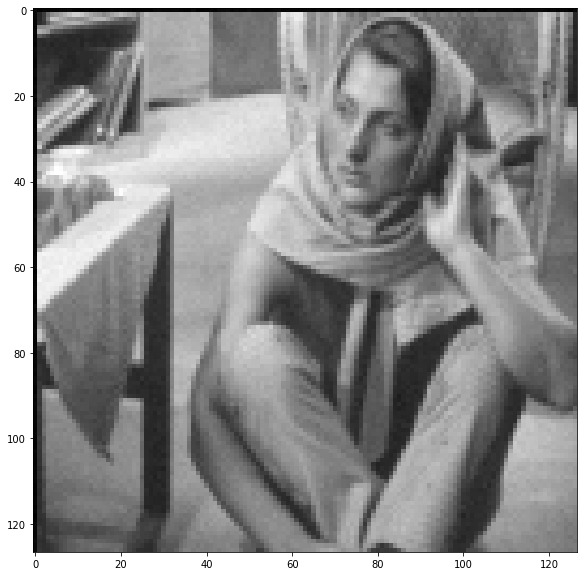

In [32]:
barb_noised = []
for barb_down in barb_downs:
    barb_noised.append(barb_down + 0.01 + np.random.normal(size=barb_down.shape, scale=.01, loc=.05))

for img in barb_noised:
    plotImage(img)

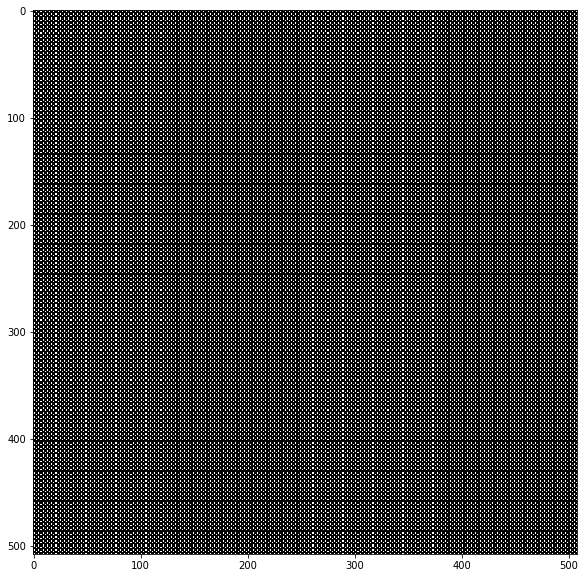

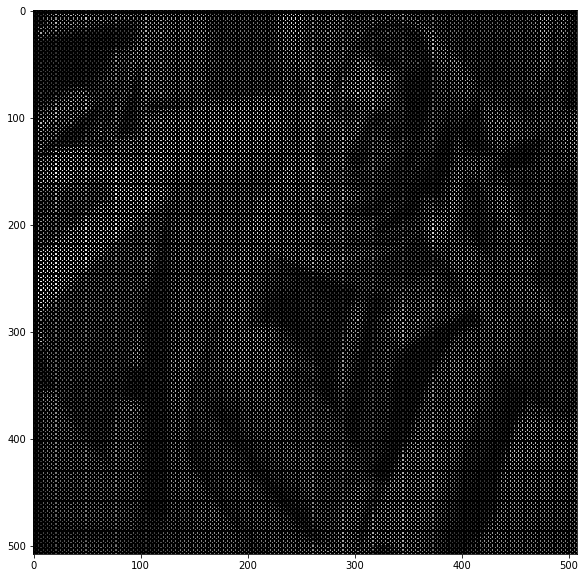

In [33]:
##On génère à présent une image en haute résolution à partir des images en basse résolution
#  translations = [(1,0),(0,1),(3,1),(1,3)]

shape = [barb_noised[0].shape[0]*step, barb_noised[0].shape[1]*step]

mat = np.zeros(shape=shape)
# Image composée des 3 images basse resolution
barb_sum = np.zeros(shape=shape)

index = 0
for x,y in translations:
    mat[x:shape[0]:step, y:shape[1]:step] = 1
    barb_sum[x:shape[0]:step, y:shape[1]:step] += barb_noised[index]
    index += 1

plotImage(mat)   
plotImage(barb_sum)

In [16]:
class Inpainting():
    
    def __init__(self, M, y, lamb=5):
        self.M = M
        self.y = y
        self.lamb = lamb
            
    # gradient works with images
    def gradient(self, z):
        return -np.transpose(self.M)*(self.y-self.M*z)
    

    def reg_l2(self, z, L):
        eps = 0.0000001
        
        div = np.divide(np.full(z.shape,self.lamb/L) , np.full(z.shape,(0.5*np.linalg.norm(z, ord=2)**2+eps)))
        sub = np.subtract(np.ones(z.shape),div)
        maxi = np.maximum(np.zeros(z.shape),sub)
        mult = np.multiply(z, maxi)
        return mult

    
    def proximal(self, z, L):
        (cA, (cV, cH, cD)) = pywt.dwt2(z, 'db7')
        cA = self.reg_l2(cA, L)
        cD = self.reg_l2(cD, L)
        cV = self.reg_l2(cV, L)
        cH = self.reg_l2(cH, L)
        res = pywt.idwt2((cA, (cV, cH, cD)), 'db7')
        return np.abs(res)
    
    def inpainting(self):
        # initialization
        L = 1
        x = self.y
        z = self.y
        
        for t in range(250):
            z = z - 1/L * (self.gradient(z))
            x_t1 = self.proximal(z, L)
            z = x_t1 + (t/(t+4))*(x_t1-x)
            x = x_t1
            if (t%50==0):
                self.lamb = self.lamb /10
        
        return x

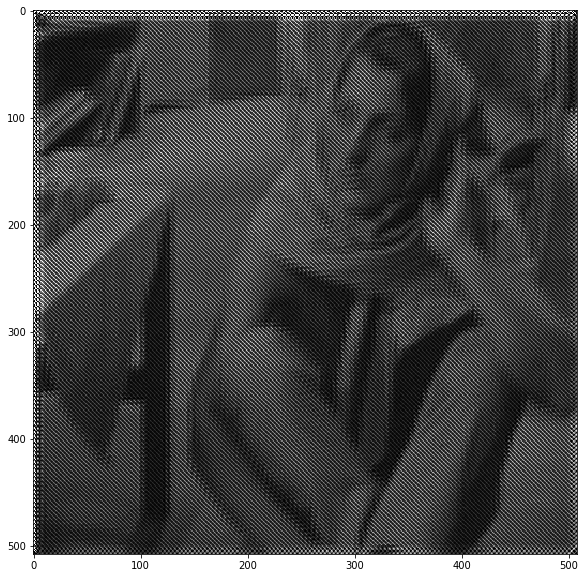

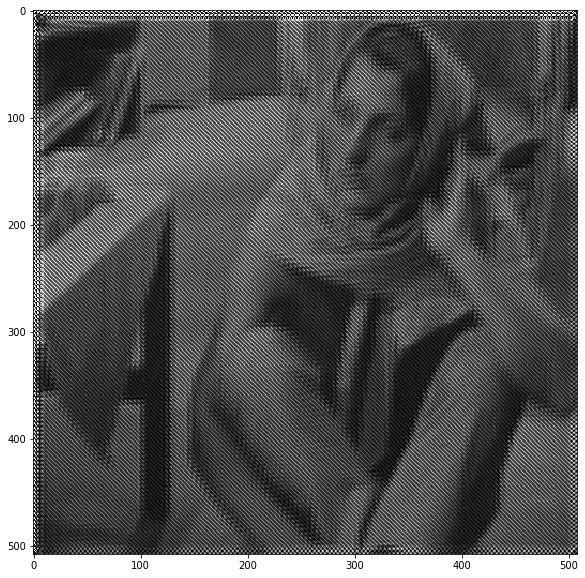

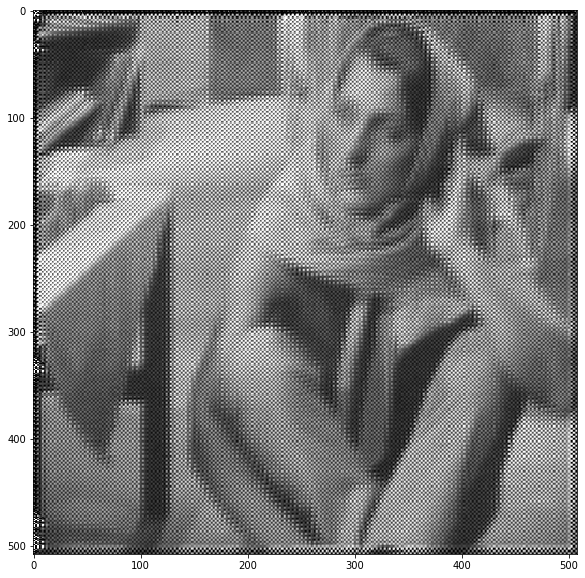

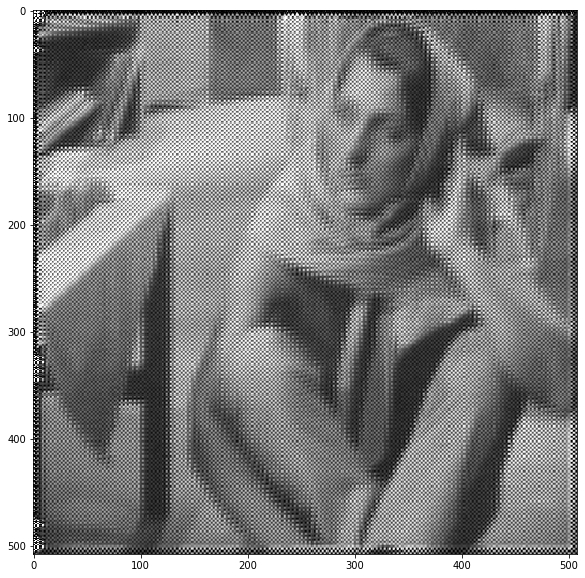

In [34]:
lambs = [1000, 2000, 8000, 10000]
outs = []
for lamb in lambs:
    imp = Inpainting(mat, barb_sum, lamb)
    output = imp.inpainting()
    output = np.maximum(0,np.minimum(1,output))
    plotImage(output)
    outs.append(output)

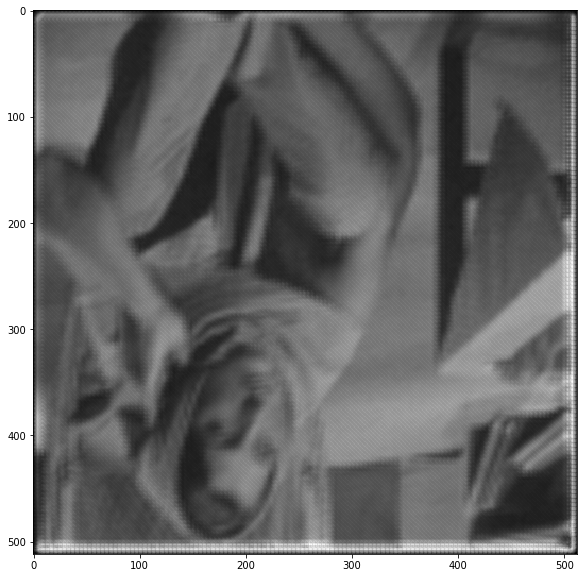

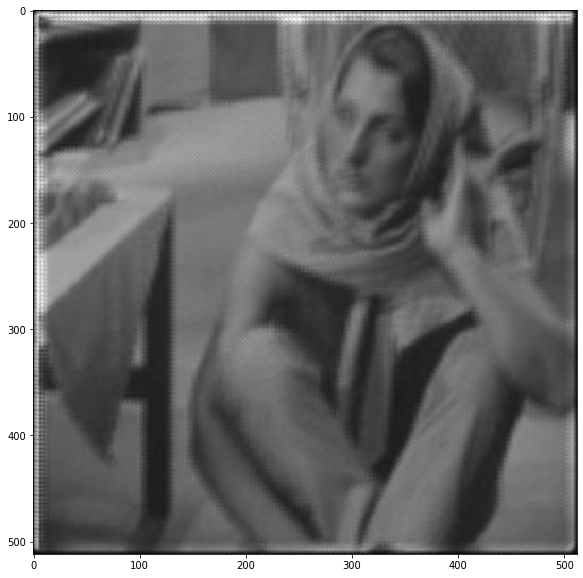

In [36]:
### On "renverse" l'image (gauche/droite et bas/haut), et on convolve dessus. L'image finale que l'on re-retourne est 
### l'image de base en haute résolution


flipped_barb = outs[0][::-1,::-1]
deconv = signal.convolve2d(flipped_barb,(1/25)*np.ones((5,5)), mode='full')
plotImage(deconv)
unflipped = deconv[::-1,::-1]
plotImage(unflipped)